# Credit Risk Analysis with Machine Learning



### Predicting the risk of client default using XGBoost, LightGBM and CatBoost



---

**Credit risk** is associated with the possibility of a client failing to meet contractual obligations, such as mortgages, credit card debts, and other types of loans.

Minimizing the risk of default is a major concern for financial institutions. For this reason, commercial and investment banks, venture capital funds, asset management companies and insurance firms, to name a few, are increasingly relying on technology to predict which clients are more prone to not honoring their debts.

**Machine Learning** models have been helping these companies to improve the accuracy of their credit risk analysis, providing a scientific method to identify potential debtors in advance.

In this article, we will build a model to predict the risk of client default for [Nubank](https://nubank.com.br/en/about-us/), a prominent Brazilian Fintech.


## About the Data

**Nubank** is a Brazilian digital bank and one of the largest Fintechs in Latin America. It is known to be a data-driven company, taking advantage of technology to make decisions and improve services. 

The data set can be downloaded [here](http://dl.dropboxusercontent.com/s/xn2a4kzf0zer0xu/acquisition_train.csv?dl=0). Some private information were hashed to keep the data anonymous.

Let's import the libraries we'll need for the analysis and take a first look at our data frame.

In [1]:
# import packages
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV, cross_val_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report, roc_curve, roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import StratifiedKFold
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

# set the aesthetic style of the plots
sns.set_style()

# filter warning messages
import warnings
warnings.filterwarnings('ignore')

In [2]:
# set default matplotlib parameters
COLOR = '#ababab'
mpl.rcParams['figure.titlesize'] = 16
mpl.rcParams['text.color'] = 'black'
mpl.rcParams['axes.labelcolor'] = COLOR
mpl.rcParams['xtick.color'] = COLOR
mpl.rcParams['ytick.color'] = COLOR
mpl.rcParams['grid.color'] = COLOR
mpl.rcParams['grid.alpha'] = 0.1

In [3]:
# import data set and create a data frame
df_credit = pd.read_csv('acquisition_train.csv')

In [4]:
# show first 5 rows
df_credit.head()

,ids,target_default,score_1,score_2,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,...,external_data_provider_fraud_score,lat_lon,marketing_channel,profile_phone_number,reported_income,shipping_state,shipping_zip_code,profile_tags,user_agent,target_fraud
0,343b7e7b-2cf8-e508-b8fd-0a0285af30aa,False,1Rk8w4Ucd5yR3KcqZzLdow==,IOVu8au3ISbo6+zmfnYwMg==,350.0,101.800832,0.259555,108.427273,0.40,25033.92,...,645,"(-29.151545708122246, -51.1386461804385)",Invite-email,514-9840782,57849.0,BR-MT,17528,"{'tags': ['n19', 'n8']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
1,bc2c7502-bbad-0f8c-39c3-94e881967124,False,DGCQep2AE5QRkNCshIAlFQ==,SaamrHMo23l/3TwXOWgVzw==,370.0,97.062615,0.942655,92.002546,0.24,NaN,...,243,"(-19.687710705798963, -47.94151536525154)",Radio-commercial,251-3659293,4902.0,BR-RS,40933,"{'tags': ['n6', 'n7', 'nim']}",Mozilla/5.0 (Linux; Android 5.0.2; SAMSUNG SM-...,NaN
2,669630dd-2e6a-0396-84bf-455e5009c922,True,DGCQep2AE5QRkNCshIAlFQ==,Fv28Bz0YRTVAT5kl1bAV6g==,360.0,100.027073,0.351918,112.892453,0.29,7207.92,...,65,"(-28.748023890412284, -51.867279334353995)",Waiting-list,230-6097993,163679.0,BR-RR,50985,"{'tags': ['n0', 'n17', 'nim', 'da']}",Mozilla/5.0 (Linux; Android 6.0.1; SGP771 Buil...,NaN
3,d235609e-b6cb-0ccc-a329-d4f12e7ebdc1,False,1Rk8w4Ucd5yR3KcqZzLdow==,dCm9hFKfdRm7ej3jW+gyxw==,510.0,101.599485,0.987673,94.902491,0.32,NaN,...,815,"(-17.520650158450454, -39.75801139933186)",Waiting-list,261-3543751,1086.0,BR-RN,37825,{'tags': ['n4']},Mozilla/5.0 (Linux; Android 6.0; HTC One X10 B...,NaN
4,9e0eb880-e8f4-3faa-67d8-f5cdd2b3932b,False,8k8UDR4Yx0qasAjkGrUZLw==,+CxEO4w7jv3QPI/BQbyqAA==,500.0,98.474289,0.532539,118.126207,0.18,NaN,...,320,"(-16.574259446978008, -39.90990074785962)",Invite-email,102-3660162,198618.0,BR-MT,52827,"{'tags': ['pro+aty', 'n19', 'da', 'b19']}",Mozilla/5.0 (Linux; Android 7.0; Pixel C Build...,NaN


## Data Analysis

In [5]:
# data frame shape
print('Number of rows: ', df_credit.shape[0])
print('Number of columns: ', df_credit.shape[1])

Number of rows:  45000
Number of columns:  43


We are working with a data set containing 43 features for 45,000 clients. `target_default` is a True/False feature and is the target variable we are trying to predict. We'll explore all features searching for outliers, treating possible missing values, and making other necessary adjustments to improve the overall quality of the model.

Let's examine the structure of the data set.

In [6]:
# data frame summary
df_credit.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 43 columns):
 #   Column                                            Non-Null Count  Dtype  
---  ------                                            --------------  -----  
 0   ids                                               45000 non-null  object 
 1   target_default                                    41741 non-null  object 
 2   score_1                                           44438 non-null  object 
 3   score_2                                           44438 non-null  object 
 4   score_3                                           44438 non-null  float64
 5   score_4                                           45000 non-null  float64
 6   score_5                                           45000 non-null  float64
 7   score_6                                           45000 non-null  float64
 8   risk_rate                                         44438 non-null  float64
 9   last_amount_borro

In [7]:
# Assuming df_credit is your DataFrame

# Count the number of columns for each data type
dtype_counts = df_credit.dtypes.value_counts()

# Print the results
print("Number of columns by data type:")
print(dtype_counts)

import pandas as pd

# Assuming df_credit is your DataFrame

# Get column names for each data type category
float_features = df_credit.select_dtypes(include=['float']).columns
object_features = df_credit.select_dtypes(include=['object']).columns
int_features = df_credit.select_dtypes(include=['int']).columns

# Print the feature names for each category
print("Float features:", list(float_features))
print("Object features:", list(object_features))
print("Integer features:", list(int_features))

Number of columns by data type:
object     21
float64    18
int64       4
Name: count, dtype: int64
Float features: ['score_3', 'score_4', 'score_5', 'score_6', 'risk_rate', 'last_amount_borrowed', 'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since', 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues', 'external_data_provider_credit_checks_last_2_year', 'external_data_provider_credit_checks_last_year', 'external_data_provider_email_seen_before', 'reported_income']
Object features: ['ids', 'target_default', 'score_1', 'score_2', 'reason', 'facebook_profile', 'state', 'zip', 'channel', 'job_name', 'real_state', 'application_time_applied', 'email', 'external_data_provider_first_name', 'lat_lon', 'marketing_channel', 'profile_phone_number', 'shipping_state', 'profile_tags', 'user_agent', 'target_fraud']
Integer features: ['application_time_in_funnel', 'external_data_provider_credit_checks_last_month', 'external_data_provider_fraud_score', 'shipping_zip_code']


We can see that some features have missing values. Let's take a closer look at them.

In [8]:
# percentage of missing values per feature
print((df_credit.isnull().sum() * 100 / df_credit.shape[0]).sort_values(ascending=False))

target_fraud                                        96.617778
last_amount_borrowed                                66.568889
last_borrowed_in_months                             66.568889
ok_since                                            58.988889
external_data_provider_credit_checks_last_2_year    50.284444
external_data_provider_credit_checks_last_year      33.608889
credit_limit                                        30.666667
n_issues                                            25.653333
facebook_profile                                     9.906667
marketing_channel                                    7.951111
job_name                                             7.413333
target_default                                       7.242222
external_data_provider_email_seen_before             4.962222
lat_lon                                              3.028889
user_agent                                           1.604444
n_bankruptcies                                       1.548889
n_defaul

First of all, note that `target_default` has missing values. As this is our target variable, we don't have a lot of options here. So, we'll eliminate all entries where `target_default` is null.

In [9]:
df_credit.dropna(subset=['target_default'], inplace=True)

Observe that `target_fraud` has almost all its entries missing. As this feature is not crucial for the project, we are dropping it.

Other variables also have a high rate of missing values, but we are not dealing with them by now.

In [10]:
# drop the column "target_fraud"
df_credit.drop('target_fraud', axis=1, inplace=True)

Now, let's examine the number of unique values for each feature.

In [11]:
# number of unique observations per column
df_credit.nunique().sort_values()

channel                                                 1
external_data_provider_credit_checks_last_2_year        1
last_borrowed_in_months                                 2
target_default                                          2
facebook_profile                                        2
external_data_provider_credit_checks_last_year          2
external_data_provider_credit_checks_last_month         4
real_state                                              5
n_defaulted_loans                                       5
email                                                   6
n_bankruptcies                                          6
score_1                                                 7
marketing_channel                                       9
shipping_state                                         25
score_2                                                35
n_issues                                               44
n_accounts                                             44
state         

The features `channel` and `external_data_provider_credit_checks_last_2_year` have only one value. As that won't be useful for the model, we can drop these two columns.

In [12]:
# drop the columns "channel" and "external_data_provider_credit_checks_last_2_year"
df_credit.drop(labels=['channel', 'external_data_provider_credit_checks_last_2_year'], axis=1, inplace=True)

Moving on with the cleaning process, to keep the data set as adequate as possible we'll remove some other columns that are not adding value to the model. Some features, as `score_1` and `score_2`, are filled with hashed values. However, we are keeping these variables as they might be useful to our model.

In [13]:
df_credit.drop(labels=['email', 'reason', 'zip', 'job_name', 'external_data_provider_first_name', 'lat_lon',
                       'shipping_zip_code', 'user_agent', 'profile_tags', 'marketing_channel',
                       'profile_phone_number', 'application_time_applied', 'ids'], axis=1, inplace=True)

Ok, now we are working with a leaner data set. Before dealing with the missing values, let's examine if there are outliers in the data set. We'll start by taking a look at some statistical details of the numerical features.

In [14]:
# show descriptive statistics
df_credit.describe()

,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,n_bankruptcies,n_defaulted_loans,n_accounts,n_issues,application_time_in_funnel,external_data_provider_credit_checks_last_month,external_data_provider_credit_checks_last_year,external_data_provider_email_seen_before,external_data_provider_fraud_score,reported_income
count,41741.000000,41741.000000,41741.000000,41741.000000,41741.000000,14133.000000,14133.000000,28632.000000,4.174100e+04,17276.000000,41606.000000,41729.000000,41741.000000,30818.000000,41741.000000,41741.000000,27720.000000,39656.000000,41741.000000,41741.0
mean,346.459836,100.006820,0.499416,99.919399,0.294451,13328.104095,40.588410,33877.220453,7.108012e+04,35.192174,0.076696,0.004625,10.639108,11.023882,247.748545,1.504396,0.504185,12.731188,500.491771,inf
std,110.102271,3.183821,0.288085,10.022703,0.101561,7918.698433,9.437936,36141.985884,5.225978e+04,21.629577,0.274820,0.080157,4.588175,4.596036,146.326172,1.114207,0.499992,125.711218,287.993121,NaN
min,0.000000,86.191572,0.000035,60.663039,0.000000,1005.180000,36.000000,0.000000,4.821180e+03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-999.000000,0.000000,403.0
25%,270.000000,97.862546,0.251595,93.182517,0.220000,7210.280000,36.000000,9975.000000,4.401958e+04,17.000000,0.000000,0.000000,7.000000,8.000000,120.000000,1.000000,0.000000,11.000000,252.000000,50910.0
50%,340.000000,100.017950,0.500174,99.977774,0.290000,12011.050000,36.000000,25213.000000,6.004409e+04,32.000000,0.000000,0.000000,10.000000,10.000000,248.000000,2.000000,1.000000,27.000000,502.000000,101623.0
75%,420.000000,102.143100,0.747630,106.630991,0.360000,18030.160000,36.000000,46492.500000,8.503289e+04,50.000000,0.000000,0.000000,13.000000,14.000000,375.000000,2.000000,1.000000,43.000000,747.000000,151248.0
max,990.000000,113.978234,0.999973,142.192400,0.900000,35059.600000,60.000000,448269.000000,5.000028e+06,141.000000,5.000000,5.000000,49.000000,49.000000,500.000000,3.000000,1.000000,59.000000,1000.000000,inf


In [15]:
# count of "inf" values in "reported_income"
np.isinf(df_credit['reported_income']).sum()

66

In [16]:
# count of values = -999 in "external_data_provider_email_seen_before"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'].value_counts()

external_data_provider_email_seen_before
-999.0    591
Name: count, dtype: int64

First of all, when examining the statistics above, we noticed that `reported_income` has 66 values displayed as "inf". Additionally, we have 591 values of `external_data_provider_email_seen_before` displayed as *-999*. We'll replace these values with NaN, so we can plot histograms to visualize the values' distributions.

In [17]:
# replace "inf" values with "nan"
df_credit['reported_income'] = df_credit['reported_income'].replace(np.inf, np.nan)

# replace "-999" values with "nan"
df_credit.loc[df_credit['external_data_provider_email_seen_before'] == -999, 'external_data_provider_email_seen_before'] = np.nan

A new data frame, containing numerical features of interest, will be created. Plotting a histogram for these features will helps us examine their distribution.

In [18]:
# data frame containing numerical features
df_credit_numerical = df_credit[['score_3', 'risk_rate', 'last_amount_borrowed', 
                                 'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since', 
                                 'n_bankruptcies', 'n_defaulted_loans', 'n_accounts', 'n_issues', 
                                 'external_data_provider_email_seen_before']]

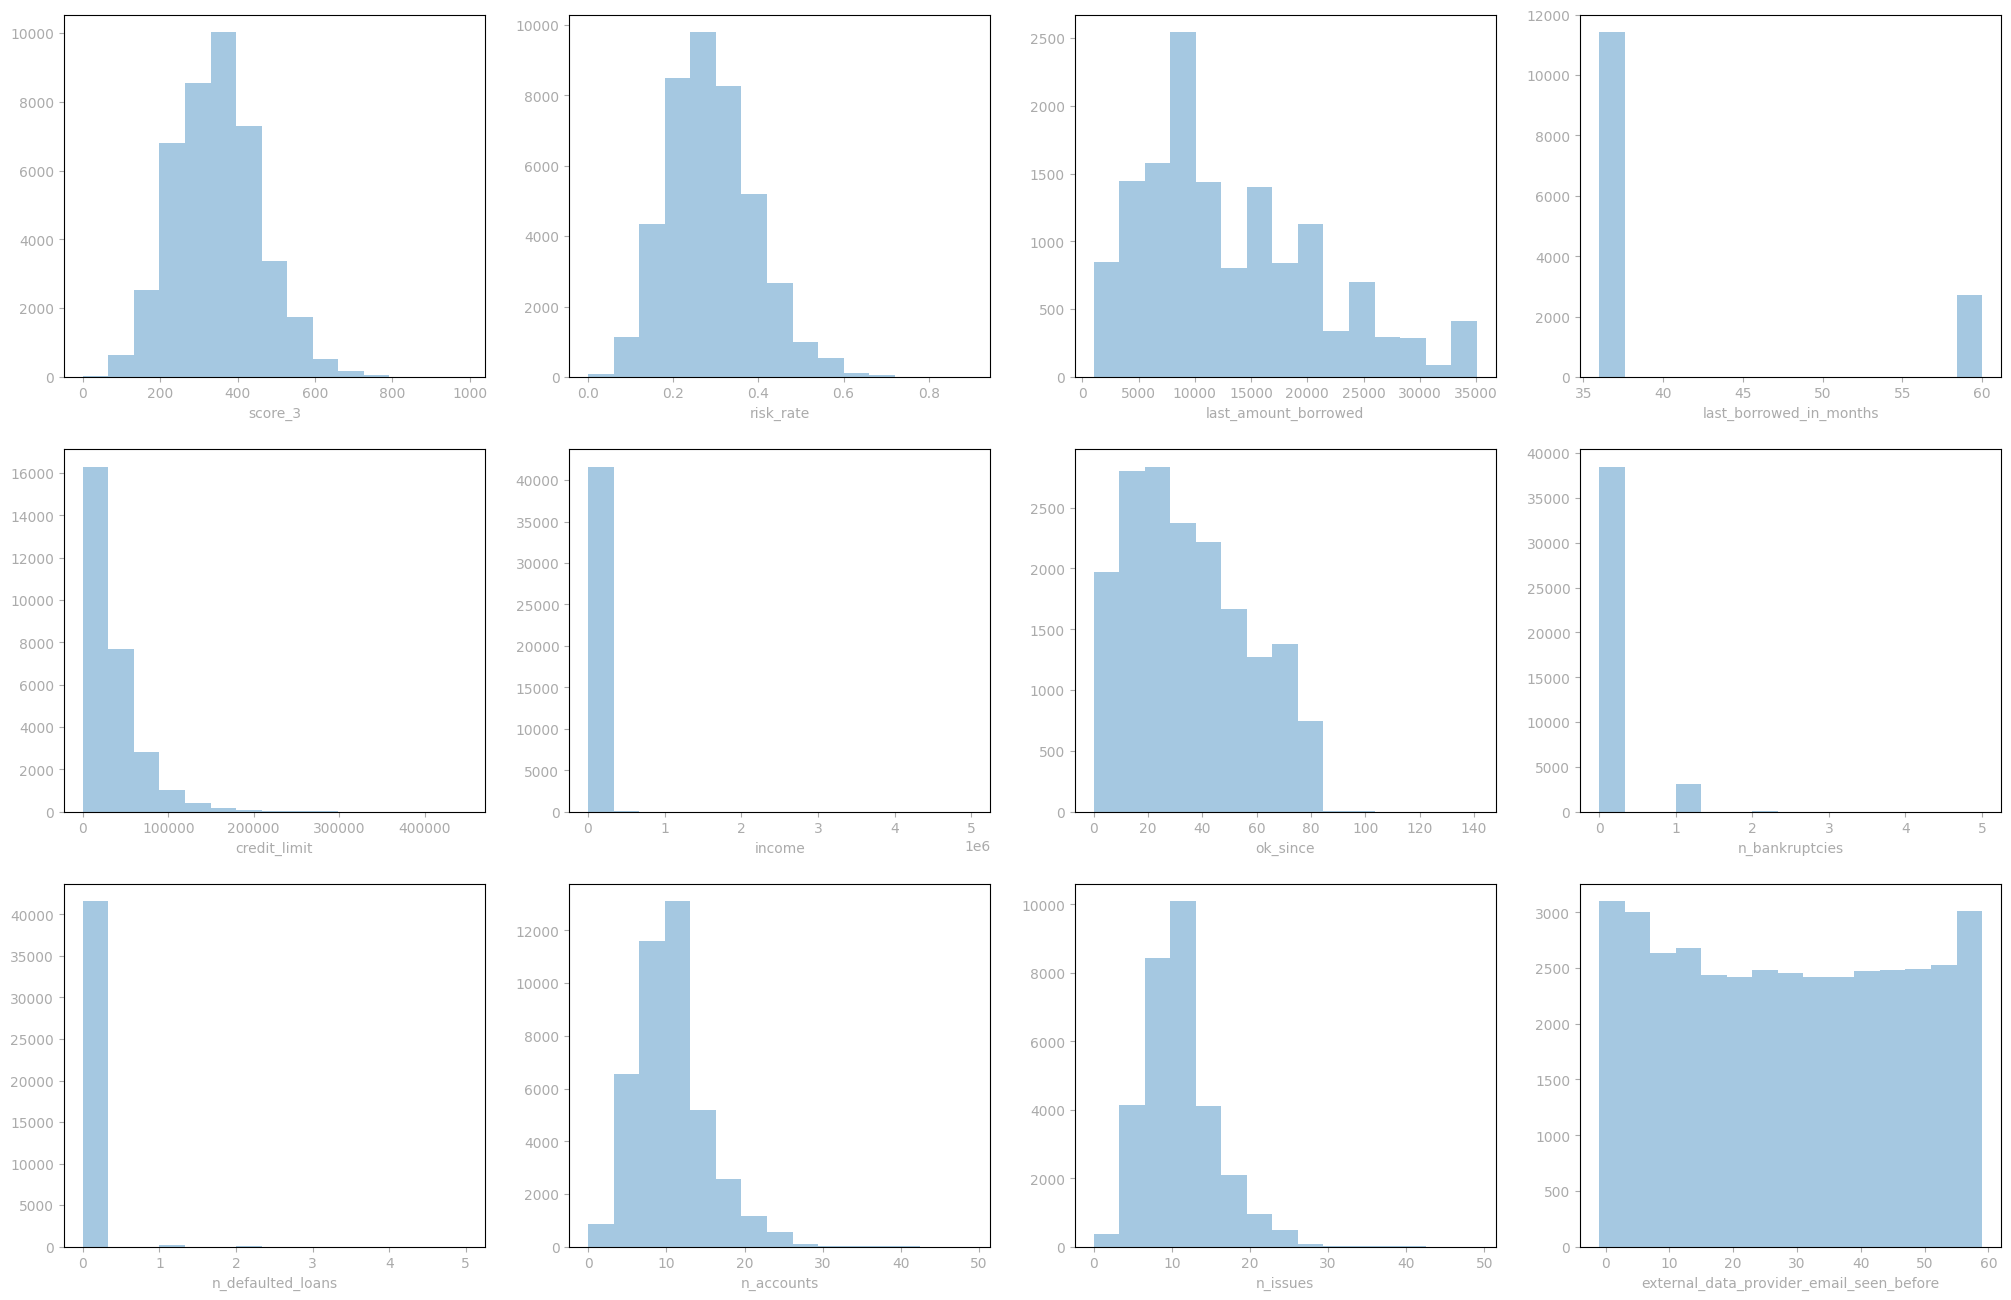

In [19]:
# plot a histogram for each of the features above 

nrows = 3
ncols = 4

fig, ax = plt.subplots(nrows=nrows, ncols=ncols, figsize=(25, 16))

r = 0
c = 0

for i in df_credit_numerical:
  sns.distplot(df_credit_numerical[i], bins=15,kde=False, ax=ax[r][c])
  if c == ncols - 1:
    r += 1
    c = 0
  else:
    c += 1

plt.show()

All these features above have missing values that need to be treated. As we can see, they have skewed distribution, which is an indication that we should fill the missing values with the median value for each feature.

It's time to deal with the missing values from the remaining 32 columns. We are filling these values according to the particularities of each feature, as below:



*   Categorical variables will be filled with the most recurrent value.
*   Numerical variables will be filled with their median values.
*   In the specific cases of `last_amount_borrowed`, `last_borrowed_in_months` and `n_issues` we'll fill the missing values with zero, as it is reasonable to believe that not every client would have values assigned to these variables.



In [20]:
df_credit.nunique().sort_values()

target_default                                         2
external_data_provider_credit_checks_last_year         2
facebook_profile                                       2
last_borrowed_in_months                                2
external_data_provider_credit_checks_last_month        4
n_defaulted_loans                                      5
real_state                                             5
n_bankruptcies                                         6
score_1                                                7
shipping_state                                        25
score_2                                               35
n_accounts                                            44
n_issues                                              44
state                                                 50
external_data_provider_email_seen_before              61
risk_rate                                             81
score_3                                               87
ok_since                       

In [21]:
df_credit_num = df_credit.select_dtypes(exclude='object').columns
df_credit_cat = df_credit.select_dtypes(include='object').columns

# fill missing values for "last_amount_borrowed", "last_borrowed_in_months" and "n_issues"
df_credit['last_amount_borrowed'].fillna(value=0, inplace=True)
df_credit['last_borrowed_in_months'].fillna(value=0, inplace=True)
df_credit['n_issues'].fillna(value=0, inplace=True)

# fill missing values for numerical variables
nimputer = SimpleImputer(missing_values=np.nan, strategy='median')
nimputer = nimputer.fit(df_credit.loc[:, df_credit_num])
df_credit.loc[:, df_credit_num] = nimputer.transform(df_credit.loc[:, df_credit_num])


# fill missing values for categorical variables
cimputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')
cimputer = cimputer.fit(df_credit.loc[:, df_credit_cat])
df_credit.loc[:, df_credit_cat] = cimputer.transform(df_credit.loc[:, df_credit_cat])


## Feature Engineering

In [22]:
# 1. Score-Based Features
df = df_credit
# 1. Score-Based Features
df['score_4_minus_score_3'] = df['score_4'] - df['score_3']
df['avg_score_5_6'] = (df['score_5'] + df['score_6']) / 2

# 2. Financial Behavior Features (Handling Zero Division)
df['debt_to_income'] = df['last_amount_borrowed'] / (df['income'] + 1e-9)  # Add small constant
df['credit_utilization'] = df['last_amount_borrowed'] / (df['credit_limit'] + 1e-9) # Add small constant
df['default_rate'] = df['n_defaulted_loans'] / (df['n_accounts'] + 1e-9) # Add small constant
df['reported_income_div_income'] = df['reported_income'] / (df['income'] + 1e-9) # Add small constant


# 4. External Data Features
df['fraud_score_times_score_1'] = df['external_data_provider_fraud_score'] * df['score_1']

# 5. Demographic/Location Features (Example - state-level default rate)
state_default_rates = df.groupby('state')['target_default'].mean().to_dict()
df['state_default_rate'] = df['state'].map(state_default_rates)

# 6. Facebook Profile Interactions (Example - combining with another feature)
df['facebook_profile_times_income'] = df['facebook_profile'] * df['income']

df['fraud_score_bin'] = pd.cut(df['external_data_provider_fraud_score'], bins=[0, 700, 800, 900, 1000], labels=['low', 'medium', 'high', 'very_high'], right = False)
df['facebook_income_credit'] = df['facebook_profile'] * df['income'] * df['credit_limit']
df['credit_available'] = df['credit_limit'] - df['last_amount_borrowed'] # Available credit
df['income_per_account'] = df['income'] / (df['n_accounts'] + 1e-9) # Income per account
df['loan_amount_to_income'] = df['last_amount_borrowed'] / (df['income'] + 1e-9)
df['n_accounts_to_credit_limit'] = df['n_accounts'] / (df['credit_limit'] + 1e-9)

# 8. Interactions between existing engineered features
df['debt_to_income_x_default_rate'] = df['debt_to_income'] * df['default_rate']
df['credit_utilization_x_fraud_score'] = df['credit_utilization'] * df['external_data_provider_fraud_score']

# 9. Polynomial features
df['income_sq'] = df['income']**2
df['last_amount_borrowed_sq'] = df['last_amount_borrowed']**2

df_credit = df
print(df.head())  # Display the updated DataFrame

  target_default                   score_1                   score_2  score_3  \
0          False  1Rk8w4Ucd5yR3KcqZzLdow==  IOVu8au3ISbo6+zmfnYwMg==    350.0   
1          False  DGCQep2AE5QRkNCshIAlFQ==  SaamrHMo23l/3TwXOWgVzw==    370.0   
2           True  DGCQep2AE5QRkNCshIAlFQ==  Fv28Bz0YRTVAT5kl1bAV6g==    360.0   
3          False  1Rk8w4Ucd5yR3KcqZzLdow==  dCm9hFKfdRm7ej3jW+gyxw==    510.0   
4          False  8k8UDR4Yx0qasAjkGrUZLw==  +CxEO4w7jv3QPI/BQbyqAA==    500.0   

      score_4   score_5     score_6  risk_rate  last_amount_borrowed  \
0  101.800832  0.259555  108.427273       0.40              25033.92   
1   97.062615  0.942655   92.002546       0.24                  0.00   
2  100.027073  0.351918  112.892453       0.29               7207.92   
3  101.599485  0.987673   94.902491       0.32                  0.00   
4   98.474289  0.532539  118.126207       0.18                  0.00   

   last_borrowed_in_months  ...  fraud_score_bin  facebook_income_credit  \
0   

## Between Numerical and Catogorical filling we need to do the feature importance

In [23]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np

# Custom function for target encoding
def target_encode(X, y=None):
    if y is None:
        raise ValueError("Target variable 'y' must be provided for target encoding.")
    
    # Calculate mean of target for each category
    encoded_X = X.copy()
    for col in encoded_X.columns:
        encoded_X[col] = encoded_X[col].map(y.groupby(X[col]).mean())
    
    # Fill NaN values (for categories not seen during fitting)
    encoded_X = encoded_X.fillna(y.mean())
    
    return encoded_X

# Copy the original DataFrame
df_credit_2 = df_credit.copy()

# Separate numerical and categorical columns
numerical_cols = df_credit_2.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = df_credit_2.select_dtypes(include=['object']).columns.tolist()
# print(df_credit_2.head(1))
# Ensure y is a Pandas Series
y = df_credit_2["target_default"]  # Target variable

# Define preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),  # Normalize numerical columns
        ('cat', FunctionTransformer(target_encode, kw_args={'y': y}), categorical_cols)  # Target encode categorical columns
    ]
)

# Apply preprocessing
X_processed = preprocessor.fit_transform(df_credit_2)

# Convert back to DataFrame
processed_columns = numerical_cols + categorical_cols
X_processed = pd.DataFrame(X_processed, columns=processed_columns)

# Drop the target column from the final feature set
# X_processed = X_processed.drop(labels=["target_default"], axis=1, errors='ignore')

# Display the processed DataFrame
print(X_processed.head())

    score_3   score_4   score_5   score_6  risk_rate  last_amount_borrowed  \
0  0.353535  0.561754  0.259535  0.585853   0.444444              0.714039   
1  0.373737  0.391232  0.942678  0.384395   0.266667              0.000000   
2  0.363636  0.497919  0.351904  0.640621   0.322222              0.205590   
3  0.515152  0.554508  0.987699  0.419965   0.355556              0.000000   
4  0.505051  0.442036  0.532537  0.704816   0.200000              0.000000   

   last_borrowed_in_months  credit_limit    income  ok_since  ...  \
0                      0.6      0.000000  0.012050   0.22695  ...   
1                      0.0      0.088621  0.019058   0.35461  ...   
2                      0.6      0.056245  0.012052   0.22695  ...   
3                      0.0      0.121782  0.012814   0.22695  ...   
4                      0.0      0.056245  0.011049   0.22695  ...   

   target_default   score_1   score_2  facebook_profile     state  real_state  \
0             0.0  0.181165  0.1934

In [24]:
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Train XGBoost model on encoded data
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss")
model.fit(X_processed, y)

# Get feature importances
importances = model.feature_importances_
features = X_processed.columns

# Sort and visualize feature importances
sorted_indices = np.argsort(importances)[::-1]

sorted_features = features[sorted_indices]
sorted_importances = importances[sorted_indices]

# plt.figure(figsize=(10, 6))
# plt.bar(range(len(importances)), importances[sorted_indices], tick_label=np.array(features)[sorted_indices])
# plt.xticks(rotation=90)
# plt.xlabel("Features")
# plt.ylabel("Importance Score")
# plt.title("Feature Importance")
# plt.show()


# Select top N most important features
top_n = 46  # Change this to the desired number of features
top_features = sorted_features[:top_n]
print("Top", top_n, "most important features:")
print(top_features)


X_processed_top_features = X_processed[top_features]

Top 46 most important features:
Index(['target_default', 'fraud_score_times_score_1', 'facebook_income_credit',
       'n_bankruptcies', 'external_data_provider_fraud_score',
       'external_data_provider_email_seen_before',
       'external_data_provider_credit_checks_last_year',
       'external_data_provider_credit_checks_last_month',
       'application_time_in_funnel', 'n_issues', 'n_accounts',
       'n_defaulted_loans', 'income', 'ok_since', 'score_4_minus_score_3',
       'credit_limit', 'last_borrowed_in_months', 'last_amount_borrowed',
       'risk_rate', 'score_6', 'score_5', 'score_4', 'reported_income',
       'debt_to_income', 'avg_score_5_6', 'credit_utilization_x_fraud_score',
       'shipping_state', 'real_state', 'state', 'facebook_profile', 'score_2',
       'score_1', 'last_amount_borrowed_sq', 'income_sq',
       'debt_to_income_x_default_rate', 'facebook_profile_times_income',
       'n_accounts_to_credit_limit', 'loan_amount_to_income',
       'income_per_accoun

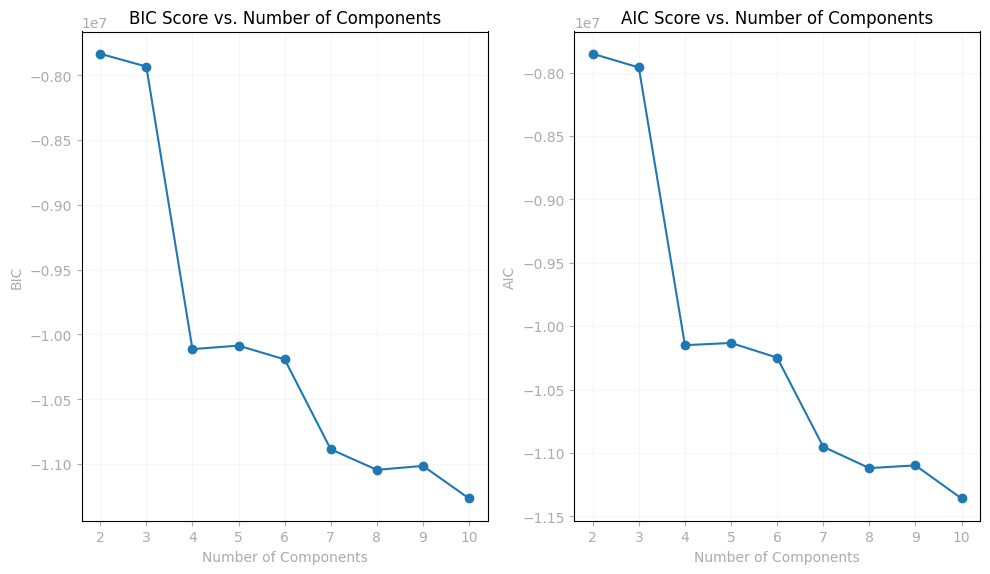

Cluster labels: [0 1 0 3 3 3 1 1 0 1]
Cluster probabilities (first 5 data points):
 [[1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [6.25343687e-26 1.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.52504124e-30 0.00000000e+00 0.00000000e+00 1.00000000e+00]
 [1.98275178e-30 0.00000000e+00 0.00000000e+00 1.00000000e+00]]


In [25]:
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
import numpy as np

# Determine a suitable range of number of components (n_components) to try.
# This is similar to choosing k in KMeans or the number of clusters you expect.
n_components_range = range(2, 11)  # Try from 2 to 10 components (adjust as needed)

# Store the Bayesian Information Criterion (BIC) and Akaike Information Criterion (AIC)
bic_scores = []
aic_scores = []

for n_components in n_components_range:
    gmm = GaussianMixture(n_components=n_components, random_state=42) # random_state for reproducibility
    gmm.fit(X_processed_top_features)  # Fit the model

    bic_scores.append(gmm.bic(X_processed_top_features))
    aic_scores.append(gmm.aic(X_processed_top_features))


# Plot the BIC and AIC scores to find the best number of components
plt.figure(figsize=(10, 6))

plt.subplot(1, 2, 1) # Subplot for BIC
plt.plot(n_components_range, bic_scores, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('BIC')
plt.title('BIC Score vs. Number of Components')
plt.grid(True)

plt.subplot(1, 2, 2) # Subplot for AIC
plt.plot(n_components_range, aic_scores, marker='o', linestyle='-')
plt.xlabel('Number of Components')
plt.ylabel('AIC')
plt.title('AIC Score vs. Number of Components')
plt.grid(True)

plt.tight_layout()
plt.show()

# Choose the best number of components based on the BIC or AIC plot.
# Lower BIC and AIC values are generally better.
best_n_components = 4  # Replace with the value you choose from the plot

# Fit the final GMM model with the chosen number of components
final_gmm = GaussianMixture(n_components=best_n_components, random_state=42)
final_gmm.fit(X_processed_top_features)

# Get cluster assignments (labels) for each data point
cluster_labels = final_gmm.predict(X_processed_top_features)

# ... (Now you can use the 'cluster_labels' for further analysis) ...

# Example: Print the cluster labels for the first 10 data points
print("Cluster labels:", cluster_labels[:10])

# Example: Get the probabilities of each data point belonging to each cluster
cluster_probabilities = final_gmm.predict_proba(X_processed_top_features)
print("Cluster probabilities (first 5 data points):\n", cluster_probabilities[:5])

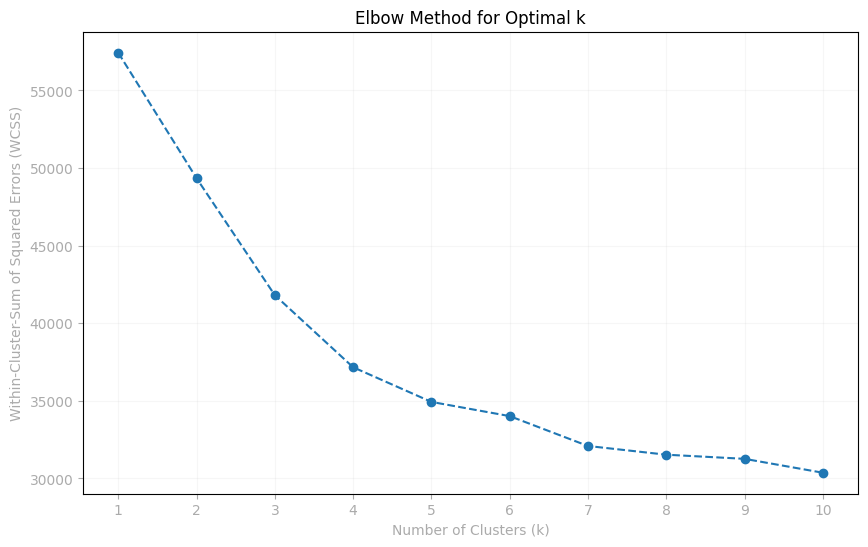

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate WCSS for different values of k
wcss = []
max_clusters = 10  # Maximum number of clusters to try
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed_top_features)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

In [27]:
from sklearn.feature_selection import SelectKBest, f_classif
import matplotlib.pyplot as plt
import numpy as np

# Apply SelectKBest
selector = SelectKBest(score_func=f_classif, k="all")  # Get scores for all features
selector.fit(X_processed, y)

# Get feature scores
feature_scores = selector.scores_
feature_names = X_processed.columns

# Sort features by importance
sorted_indices = np.argsort(feature_scores)[::-1]
sorted_scores = feature_scores[sorted_indices]
sorted_names = feature_names[sorted_indices]

# # Plot feature importance
# plt.figure(figsize=(12, 6))
# plt.bar(range(len(sorted_scores)), sorted_scores, tick_label=sorted_names)
# plt.xticks(rotation=90)
# plt.xlabel("Features")
# plt.ylabel("F-Score")
# plt.title("Feature Importance (F-Score)")
# plt.show()



# Select top N most important features
# top_n = 45645  # Change this to the desired number of features
top_features = sorted_names[:top_n]
print("Top", top_n, "most important features:")
print(top_features)


X_processed_top_features = X_processed[top_features]


Top 46 most important features:
Index(['target_default', 'facebook_profile_times_income',
       'facebook_income_credit', 'fraud_score_times_score_1', 'score_2',
       'score_1', 'facebook_profile', 'risk_rate',
       'external_data_provider_email_seen_before', 'shipping_state',
       'state_default_rate', 'state', 'score_3', 'score_4_minus_score_3',
       'income', 'real_state', 'debt_to_income', 'loan_amount_to_income',
       'last_amount_borrowed_sq', 'n_issues', 'application_time_in_funnel',
       'last_borrowed_in_months', 'last_amount_borrowed', 'n_accounts',
       'n_bankruptcies', 'credit_available', 'debt_to_income_x_default_rate',
       'external_data_provider_credit_checks_last_year', 'credit_limit',
       'credit_utilization', 'credit_utilization_x_fraud_score', 'income_sq',
       'default_rate', 'ok_since', 'score_5',
       'external_data_provider_credit_checks_last_month', 'income_per_account',
       'score_4', 'reported_income_div_income', 'avg_score_5_6',
 

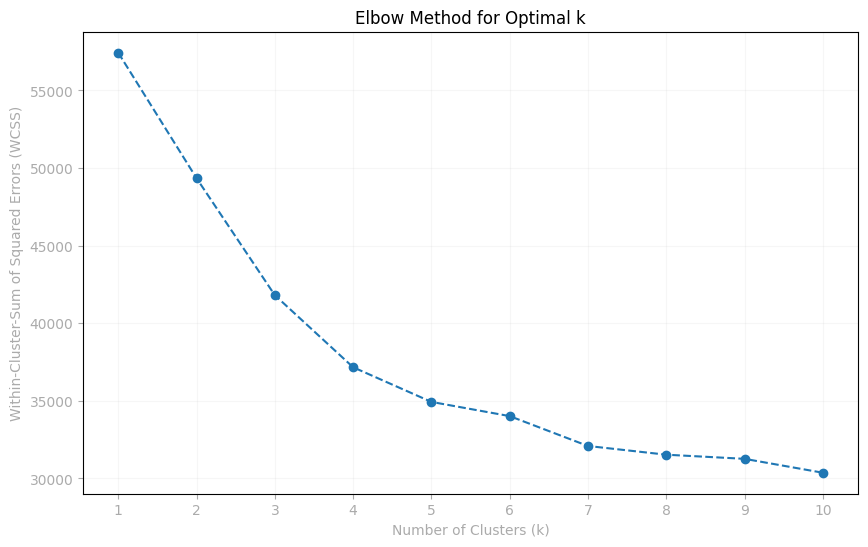

In [28]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate WCSS for different values of k
wcss = []
max_clusters = 10  # Maximum number of clusters to try
for k in range(1, max_clusters + 1):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_processed_top_features)
    wcss.append(kmeans.inertia_)  # Inertia is the WCSS

# Plot the Elbow Method graph
plt.figure(figsize=(10, 6))
plt.plot(range(1, max_clusters + 1), wcss, marker='o', linestyle='--')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Within-Cluster-Sum of Squared Errors (WCSS)')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, max_clusters + 1))
plt.grid()
plt.show()

## END


In [29]:
df_credit.isnull().sum()

target_default                                      0
score_1                                             0
score_2                                             0
score_3                                             0
score_4                                             0
score_5                                             0
score_6                                             0
risk_rate                                           0
last_amount_borrowed                                0
last_borrowed_in_months                             0
credit_limit                                        0
income                                              0
facebook_profile                                    0
state                                               0
real_state                                          0
ok_since                                            0
n_bankruptcies                                      0
n_defaulted_loans                                   0
n_accounts                  

After handling the missing values, case by case, we now have a data set free of null values.

We'll now preprocess the data, converting the categorical features into numerical values. `LabelEncoder` will be used for the binary variables while `get_dummies` will be used for the other categorical variables.

In [30]:
# bin_var = df_credit.nunique()[df_credit.nunique() == 2].keys().tolist()
# num_var = [col for col in df_credit.select_dtypes(['int', 'float']).columns.tolist() if col not in bin_var]
# cat_var = [col for col in df_credit.select_dtypes(['object']).columns.tolist() if col not in bin_var]

# df_credit_encoded = df_credit.copy()
  
# # label encoding for the binary variables
# le = LabelEncoder()
# for col in bin_var:
#   df_credit_encoded[col] = le.fit_transform(df_credit_encoded[col])

# # encoding with get_dummies for the categorical variables
# df_credit_encoded = pd.get_dummies(df_credit_encoded, columns=cat_var)

# df_credit_encoded.head()
# df_transposed = df_credit_encoded.head()

# # Display the transposed DataFrame
# print(df_transposed)

# # Iterate through each column (originally rows) and inspect the data
# for column_name, column_data in df_transposed.items():
#     print(f"\nColumn: {column_name}")
#     print(column_data)

After encoding the categorical variables, let's start working on the machine learning models.

## clustering

In [31]:
from sklearn.cluster import KMeans

# Perform K-Means clustering on normalized data
kmeans = KMeans(n_clusters=5, random_state=42)
clusters = kmeans.fit_predict(X_processed)

# Add cluster labels to the original dataset
X_processed['Cluster'] = clusters

print(pd.Series(clusters).value_counts().sort_index())
# Display the clustered data
(X_processed.head())

0     8657
1     8296
2     3301
3    17078
4     4409
Name: count, dtype: int64


,score_3,score_4,score_5,score_6,risk_rate,last_amount_borrowed,last_borrowed_in_months,credit_limit,income,ok_since,...,score_1,score_2,facebook_profile,state,real_state,shipping_state,fraud_score_times_score_1,facebook_profile_times_income,facebook_income_credit,Cluster
0,0.353535,0.561754,0.259535,0.585853,0.444444,0.714039,0.6,0.000000,0.012050,0.22695,...,0.181165,0.193467,0.238321,0.136666,0.147915,0.161480,0.153846,0.000000,0.126131,4
1,0.373737,0.391232,0.942678,0.384395,0.266667,0.000000,0.0,0.088621,0.019058,0.35461,...,0.116603,0.132917,0.120118,0.153306,0.147915,0.128368,0.100000,0.120118,0.126131,1
2,0.363636,0.497919,0.351904,0.640621,0.322222,0.205590,0.6,0.056245,0.012052,0.22695,...,0.116603,0.100309,0.120118,0.150190,0.173175,0.221777,0.285714,0.120118,0.126131,0
3,0.515152,0.554508,0.987699,0.419965,0.355556,0.000000,0.0,0.121782,0.012814,0.22695,...,0.181165,0.208456,0.120118,0.128889,0.173175,0.150662,0.076923,0.120118,0.126131,3
4,0.505051,0.442036,0.532537,0.704816,0.200000,0.000000,0.0,0.056245,0.011049,0.22695,...,0.231838,0.253831,0.238321,0.153306,0.173175,0.161480,0.444444,0.000000,0.000000,3


In [32]:
import pandas as pd

# Assuming 'Cluster' column contains the cluster labels
cluster_summary = X_processed.groupby('Cluster').mean()  # Use .median() for median values
df_normalized = X_processed
# Display the cluster summary
print(cluster_summary)

          score_3   score_4   score_5   score_6  risk_rate  \
Cluster                                                      
0        0.350092  0.497981  0.496096  0.481579   0.325951   
1        0.347614  0.495665  0.501808  0.483122   0.325033   
2        0.361387  0.497500  0.492499  0.481683   0.352816   
3        0.349451  0.497787  0.501532  0.480794   0.324695   
4        0.347524  0.495961  0.498377  0.480886   0.323948   

         last_amount_borrowed  last_borrowed_in_months  credit_limit  \
Cluster                                                                
0                    0.377200                 0.670463      0.070790   
1                    0.000000                 0.000000      0.069559   
2                    0.133799                 0.238413      0.067929   
3                    0.000000                 0.000000      0.069251   
4                    0.377784                 0.673486      0.069025   

           income  ok_since  ...  target_default   score_1  

In [33]:
from sklearn.feature_selection import f_classif

X = df_normalized.drop(columns=['Cluster', 'target_default'])
y = df_normalized['Cluster']

print("Cluster in df_normalized:", 'Cluster' in df_normalized.columns)  # Should be True
print("Cluster in X:", 'Cluster' in X.columns)  # Should be False



f_scores, p_values = f_classif(X, y)

# Create a DataFrame to display results
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'F-Score': f_scores,
    'P-Value': p_values
})

# Sort by F-Score (higher F-Score means more important)
feature_importance = feature_importance.sort_values(by='F-Score', ascending=False)

print(feature_importance)

Cluster in df_normalized: True
Cluster in X: False
                                            Feature        F-Score  \
42                    facebook_profile_times_income  143832.495126   
16   external_data_provider_credit_checks_last_year  124664.336972   
43                           facebook_income_credit   58445.753105   
6                           last_borrowed_in_months   54972.671655   
29                            loan_amount_to_income   18342.045433   
22                                   debt_to_income   18342.045433   
5                              last_amount_borrowed   15199.249202   
34                          last_amount_borrowed_sq    4572.397319   
37                                 facebook_profile    2158.571709   
41                        fraud_score_times_score_1    1108.797614   
23                               credit_utilization     632.032570   
32                 credit_utilization_x_fraud_score     462.171915   
27                                 cred

In [34]:
X.nunique().sort_values()

external_data_provider_credit_checks_last_year         2
facebook_profile                                       2
last_borrowed_in_months                                3
facebook_income_credit                                 4
external_data_provider_credit_checks_last_month        4
real_state                                             5
n_defaulted_loans                                      5
n_bankruptcies                                         6
score_1                                                7
facebook_profile_times_income                          7
shipping_state                                        25
score_2                                               35
default_rate                                          39
n_accounts                                            44
n_issues                                              44
state_default_rate                                    48
state                                                 48
debt_to_income_x_default_rate  

## Machine Learning Models

We are experimenting with the following 3 boosting algorithms to determine which one yields better results:


*   XGBoost
*   LightGBM
*   CatBoost

Before starting with the models, let's split the data into training and test sets.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, stratify=y, test_size=0.3)
print(len(X_train), len(X_test))
print("NaN in X_train:", X_train.isna().sum().sum())
print("NaN in y_train:", y_train.isna().sum())
print("Infinite values in X:", np.isinf(y_train.values).sum())

29218 12523
NaN in X_train: 0
NaN in y_train: 0
Infinite values in X: 0


Now, as we are dealing with an unbalanced data set, we'll standardize and resample the training set, with `StandardScaler` and `RandomUnderSampler`, respectively.

In [36]:
# scaler = MinMaxScaler().fit(X_train)
# X_train = scaler.transform(X_train)

# resample
# rus = RandomUnderSampler()
# X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

from imblearn.over_sampling import SMOTE

# Apply SMOTE to balance clusters
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train_rus, y_train_rus = smote.fit_resample(X_train, y_train)

X_train_rus, y_train_rus = (X_train, y_train)

# Check new cluster distribution
print(pd.Series(y_train_rus).value_counts())

print(X_train_rus)


Cluster
3    11954
0     6060
1     5807
4     3086
2     2311
Name: count, dtype: int64
        score_3   score_4   score_5   score_6  risk_rate  \
17026  0.242424  0.445480  0.710308  0.537251   0.300000   
41105  0.202020  0.352786  0.538288  0.524918   0.311111   
6912   0.262626  0.459718  0.087329  0.416233   0.266667   
34866  0.414141  0.613170  0.704109  0.414419   0.555556   
39826  0.202020  0.573241  0.421338  0.530583   0.466667   
...         ...       ...       ...       ...        ...   
20017  0.272727  0.397381  0.442631  0.452878   0.300000   
8600   0.444444  0.557858  0.472437  0.426096   0.177778   
4979   0.333333  0.480059  0.739298  0.448647   0.177778   
16677  0.333333  0.442820  0.840087  0.556820   0.266667   
17670  0.222222  0.624662  0.289509  0.441755   0.400000   

       last_amount_borrowed  last_borrowed_in_months  credit_limit    income  \
17026               0.00000                      0.0      0.056245  0.014057   
41105               0.00000   

We're all set up to start evaluating the models. It's worth mentioning that we should consider `Precision`, `Recall` and `F1 Score` as evaluation metrics, for the following reasons:


*   **Precision** will give us the proportion of positive identifications that were indeed correct. It can be defined as:

${Precision} = \frac{True Positives}{True Positives + False Positives}$


*   **Recall** will determine the proportion of real positives that were 
correctly identified, and it can be defined as:

${Recall} = \frac{True Positives}{True Positives + False Negatives}$

*   **F1 Score** is a metric that is useful when we need to seek a balance between precision and recall. The formula is defined as:

${F_1} = 2 \times \frac{Precision \times Recall}{Precision + Recall}$


Since our objective is to minimize company loss, predicting the risk of client default, a good recall rate is desirable because we want to identify the maximum amount of clients that are indeed prone to stop paying their debts, thus, we are pursuing a small number of *False Negatives*.

Additionally, we also seek to minimize the number of False Positives because we don't want clients to be mistakenly identified as defaulters. Therefore, a good precision rate is also desirable.

However, there is always a tradeoff between precision and recall. For this article, we chose to give more emphasis to recall, using it as our evaluation metric. 

We'll use Cross-Validation to get better results. Instead of simply splitting the data into a train and test set, the cross_validate method splits our training data into k number of Folds, making better use of the data. In our case, we'll perform 5-fold cross-validation, as we let the default k value.

In [37]:
# define the function val_model
def val_model(X, y, clf, show=True):
    """
    Apply cross-validation on the training set.

    # Arguments
        X: DataFrame containing the independent variables.
        y: Series containing the target vector.
        clf: Scikit-learn estimator instance.
        
    # Returns
        float, mean value of the cross-validation scores.
    """
    
    X = np.array(X)
    y = np.array(y)

    pipeline = make_pipeline(MinMaxScaler(), clf)
    scores = cross_val_score(pipeline, X, y, scoring='recall')

    if show == True:
        print(f'Recall: {scores.mean()}, {scores.std()}')
    
    return scores.mean()

Notice that all three models yielded similar results. We'll now tune some hyperparameters on the models to see if we can achieve higher score values. The method utilized here is `GridSearchCV`, which will search over specified parameter values for each estimator.

### XGBoost

Let's start by making some adjustments to the XGBoost estimator. XGBoost is known for being one of the most effective Machine Learning algorithms, due to its good performance on structured and tabular datasets on classification and regression predictive modeling problems. It is highly customizable and counts with a large range of hyperparameters to be tuned.

For the XGBoost model, we'll tune the following hyperparameters, according to [the official documentation](https://xgboost.readthedocs.io/en/latest/parameter.html):


*   `n_estimators` - The number of trees in the model
*   `max_depth` - Maximum depth of a tree
*   `min_child_weight` - Minimum sum of instance weight needed in a child
*   `gamma` - Minimum loss reduction required to make a further partition on a leaf node of the tree
*   `learning_rate` - Step size shrinkage used in the update to prevents overfitting

In [38]:
# XGBoost
xgb = XGBClassifier()

# parameter to be searched
param_grid = {
    'n_estimators': [100, 200],  # Start from 100, avoid 0
    # 'max_depth': [3, 5, 7, 10],  # 1 is too low; 7-10 adds complexity
    # 'min_child_weight': [1, 3, 5],  # Avoid too high values unless overfitting
    # 'gamma': [0, 0.1, 0.3, 0.5],  # Small values help regularization
    # 'learning_rate': [0.01, 0.05, 0.1, 0.2],  # 0.001 is too small, slows training
    # 'subsample': [0.7, 0.8, 0.9],  # Avoid 1.0 to prevent overfitting
    # 'colsample_bytree': [0.7, 0.8, 0.9],  # Controls feature sampling
    # 'lambda': [0.01, 0.1, 1, 10],  # L2 Regularization
    # 'alpha': [0, 0.1, 1, 10]  # L1 Regularization
}


# find the best parameter   
# kfold = StratifiedKFold(n_splits=5, shuffle=False)
# grid_search = GridSearchCV(xgb, param_grid, scoring="recall", n_jobs=-1, cv=kfold)
# grid_result = grid_search.fit(X_train_rus, y_train_rus)

# print(f'Best result: {grid_result.best_score_} for {grid_result.best_params_}')
# print(grid_result)

# Best result: 0.7522522522522523 for {'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'min_child_weight': 3, 'n_estimators': 100

After tuning some hyperparameters, all three models displayed betters results. It is worth mentioning that XGBoost presented a great score increase, while LightGBM and CatBoost saw a meager improvement.

Now, we can check how these models perform on the **test set**. To help us visualize the results, we are plotting a **confusion matrix**.

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2597
           1       1.00      1.00      1.00      2489
           2       0.99      0.99      0.99       990
           3       1.00      1.00      1.00      5124
           4       1.00      1.00      1.00      1323

    accuracy                           1.00     12523
   macro avg       1.00      1.00      1.00     12523
weighted avg       1.00      1.00      1.00     12523



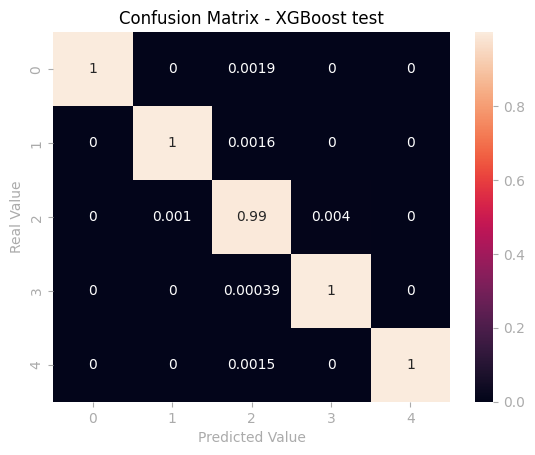

AUC Score: 0.9999968534849103


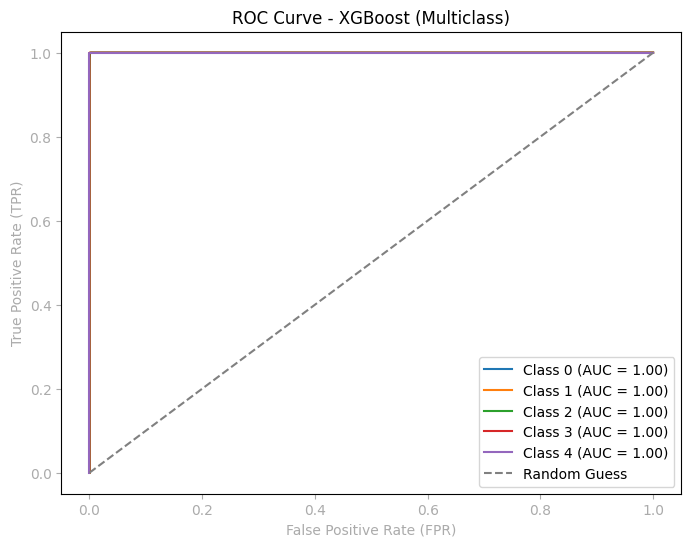

In [43]:
# final XGBoost model
xgb = XGBClassifier(
    max_depth=5, 
    learning_rate=0.01,  
    n_estimators=100, 
    gamma=1,  
    min_child_weight=6,  
    # subsample=0.8,  
    # colsample_bytree=0.8,  
    # reg_lambda=1,  
    # reg_alpha=0.1
)

from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
# xgb = RandomForestClassifier(
#     n_estimators=200,  # Number of trees in the forest
#     max_depth=8,        # Maximum depth of the trees
#     #... other hyperparameters (e.g., min_samples_split, min_samples_leaf, etc.)...
#     random_state=42,     # For reproducibility
# )

# xgb = AdaBoostClassifier(n_estimators=100, learning_rate=0.01, algorithm='SAMME', random_state=42)  # Adjust parameters

xgb.fit(X_train_rus, y_train_rus)
# prediction
scaler = MinMaxScaler().fit(X_test)
X_test_xgb = scaler.transform(X_test)
y_pred_xgb = xgb.predict(X_test_xgb)

# classification report
print(classification_report(y_test, y_pred_xgb))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_test, y_pred_xgb, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost test')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()





from sklearn.preprocessing import label_binarize
y_pred_xgb = xgb.predict_proba(X_test_xgb)
n_classes = len(np.unique(y_test))
y_test_binarized = label_binarize(y_test, classes=np.arange(n_classes))

auc_score = roc_auc_score(y_test_binarized, y_pred_xgb)
print("AUC Score:", auc_score)

# Plot ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_binarized[:, i], y_pred_xgb[:, i])
    roc_auc[i] = roc_auc_score(y_test_binarized[:, i], y_pred_xgb[:, i])

# Plot ROC curves
plt.figure(figsize=(8, 6))
for i in range(n_classes):
    plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve - XGBoost (Multiclass)')
plt.legend()
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      6060
           1       1.00      1.00      1.00      5807
           2       0.99      1.00      1.00      2311
           3       1.00      1.00      1.00     11954
           4       1.00      1.00      1.00      3086

    accuracy                           1.00     29218
   macro avg       1.00      1.00      1.00     29218
weighted avg       1.00      1.00      1.00     29218



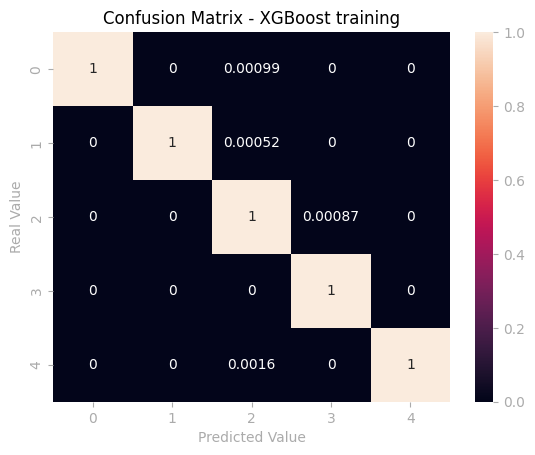

In [44]:
yo = xgb.predict(X_train_rus)

# classification report
print(classification_report(y_train_rus, yo))

# confusion matrix
fig, ax = plt.subplots()
sns.heatmap(confusion_matrix(y_train_rus, yo, normalize='true'), annot=True, ax=ax)
ax.set_title('Confusion Matrix - XGBoost training')
ax.set_xlabel('Predicted Value')
ax.set_ylabel('Real Value')

plt.show()

In [45]:
def func(user_input):
    required_columns = [
    'score_3', 'score_4', 'score_5', 'score_6', 'risk_rate', 'last_amount_borrowed',
    'last_borrowed_in_months', 'credit_limit', 'income', 'ok_since', 'n_bankruptcies',
    'n_defaulted_loans', 'n_accounts', 'n_issues', 'external_data_provider_credit_checks_last_2_year',
    'external_data_provider_credit_checks_last_year', 'external_data_provider_credit_checks_last_month',
    'external_data_provider_email_seen_before', 'reported_income', 'application_time_in_funnel',
    'external_data_provider_fraud_score', 'shipping_state', 'facebook_profile', 'state', 'score_1', 'score_2'
    ]      

    for col in required_columns:
        if col not in user_input:
            user_input[col] = None 
    
    return user_input
    

In [46]:
import numpy as np
import pandas as pd
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier

# Example user input
user_input = {
    'score_3': 0.5, 'score_4': np.nan, 'score_5': 0.7, 'score_6': np.nan,
    'risk_rate': 0.2, 'last_amount_borrowed': 1000, 'last_borrowed_in_months': 12,
    'credit_limit': 5000, 'income': np.nan, 'ok_since': 24, 'n_bankruptcies': 9,
    'n_defaulted_loans': 1, 'n_accounts': 3, 'n_issues': 2,
    'external_data_provider_credit_checks_last_2_year': 6,
    'external_data_provider_credit_checks_last_year': 3,
    'external_data_provider_email_seen_before': 1, 'reported_income': 50000,
    'application_time_in_funnel': 5, 'external_data_provider_credit_checks_last_month': 0,
    'external_data_provider_fraud_score': 50, 'shipping_state': 'CA',
    'facebook_profile': 'yes', 'state': 'CA', 'score_1': 'A', 'score_2': '2', "real_state":'a'
}

user_input = {
    'score_3': 0.410, 'score_4': 0.520, 'score_5': 0.480, 'score_6': 0.500,
    'risk_rate': 0.45, 'last_amount_borrowed': 0.600, 'last_borrowed_in_months': 0.900,
    'credit_limit': 0.050, 'income': 0.005, 'ok_since': 0.050, 'n_bankruptcies': 3.0,
    'n_defaulted_loans': 20.0, 'n_accounts': 25.0, 'n_issues': 5.0,
    'external_data_provider_credit_checks_last_2_year': 15.0,
    'external_data_provider_credit_checks_last_year': 30.0,
    'external_data_provider_email_seen_before': 0, 'reported_income': 0.0005,
    'application_time_in_funnel': 900, 'external_data_provider_credit_checks_last_month': 5.0,
    'external_data_provider_fraud_score': 0.900, 'shipping_state': 'Unknown',
    'facebook_profile': 'False', 'state': 'Unknown', 'score_1': 'Unknown', 'score_2': 'Unknown', "real_state": 'Unknown'
}







reasoning = {
    '1': "High Risk \n Borrower has taken large loans frequently and shows concerning risk patterns in their behavior, though they haven't defaulted yet. This combination suggests a higher chance of future payment issues.",

    '2': "Low Risk \n Borrower has a cautious borrowing pattern with small loan amounts, consistent repayment behavior, and strong reliability indicators across all measures.",

    '22': "Low-Medium Risk \n Borrower shows good overall reliability but has taken moderate-sized loans more frequently than low-risk borrowers. Their behavior suggests slightly more caution is needed.",

    '3': "Medium Risk \n While the borrower shows generally positive patterns, their risk indicators are higher than usual and their scores show more variation, suggesting the need for closer monitoring.",

    '0': "Very High Risk \n Borrower has a history of defaults and shows the highest risk scores across multiple measures. Their patterns strongly suggest a high probability of payment problems."
}
# Convert user input to DataFrame

user_input = func(user_input)

user_df = pd.DataFrame([user_input])

# Ensure the user input has the same columns as the training data
user_df = user_df.reindex(columns=X.columns, fill_value=np.nan)
# Separate numerical and categorical columns
numerical_cols = user_df.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_cols = user_df.select_dtypes(include=['object']).columns.tolist()

# Define imputers
nimputer = SimpleImputer(missing_values=np.nan, strategy='median')  # Numerical imputer
cimputer = SimpleImputer(missing_values=np.nan, strategy='most_frequent')  # Categorical imputer

# Fit the imputers on the training data
nimputer.fit(X[numerical_cols])
cimputer.fit(X[categorical_cols])

user_df.loc[:, categorical_cols] = cimputer.transform(user_df.loc[:, categorical_cols])
user_df.loc[:, df_credit_num] = nimputer.transform(user_df.loc[:, df_credit_num])


preprocessor = ColumnTransformer(
    transformers=[
        ('num', MinMaxScaler(), numerical_cols),  # Normalize numerical columns
        ('cat', FunctionTransformer(target_encode, kw_args={'y': y}), categorical_cols)  # Target encode categorical columns
    ]
)

preprocessor.fit(X, y)

user_processed = preprocessor.transform(user_df)

# Make prediction
prediction = xgb.predict(user_processed)
prediction_proba = xgb.predict_proba(user_processed)

print("Prediction:", prediction)
print(reasoning[str(prediction[0])])
print("Prediction Probability:", prediction_proba)

# 6 → 3 → 7 → 1 → 2 → 0 → 5 → 4

ValueError: The feature names should match those that were passed during fit.
Feature names seen at fit time, yet now missing:
- avg_score_5_6
- credit_available
- credit_utilization
- credit_utilization_x_fraud_score
- debt_to_income
- ...


## Conclusion

The main objective of this article was to build a machine learning algorithm that would be able to identify potential defaulters and therefore reduce company loss. The best model possible would be the one that could minimize false negatives, identifying all defaulters among the client base, while also minimizing false positives, preventing clients to be wrongly classified as defaulters.

Meeting these requirements can be quite tricky as there is a tradeoff between precision and recall, meaning that increasing the value of one of these metrics often decreases the value of the other. Considering the importance of minimizing company loss, we decided to give more emphasis on reducing false positives, searching for the best hyperparameters that could increase the recall rate.

Among the three **Gradient Boosting Algorithms** tested, **XGBoost** yielded the best results, with a recall rate of 81%, although it delivered an undesired 56% of false positives. On the other hand, **LightGBM** and **CatBoost** delivered a better count of false positives, with 38% and 33% respectively, but their false negatives were substantially higher than that of XGBoost, resulting in a weaker recall rate.

This article presents a classic evaluation metrics dilemma. In this case, it would be up to the company's decision-makers to analyze the big picture, with the aid of the machine learning algorithms, and decide the best plan to follow. Of course, in a future article, we can test a different approach to achieve a more desirable result, such as taking advantage of deep learning models.